In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from joblib import Parallel, delayed
import scanpy as sc

import os
from tqdm import tqdm

from matplotlib import rc_context

In [2]:
temp = pd.read_pickle(r'.\results\patch_type.pkl')
bm_homotypic = temp['bm_homotypic_patch']
bm_heterotypic = temp['bm_heterotypic_patch']
uc_homotypic = temp['uc_homotypic_patch']
uc_heterotypic = temp['uc_heterotypic_patch']

In [3]:
len(bm_homotypic)

7980

In [4]:
len(bm_heterotypic)

1524

In [5]:
len(uc_homotypic)

6578

In [6]:
len(uc_heterotypic)

5000

In [8]:
proxi_df = pd.read_csv(r'.\results\proxi_df.csv',index_col=0)
edge_dir = r'.\results\explainer\explained_edges'

# Visualize cci motif

In [143]:
test_explanation = pd.read_pickle(r'.\results\explainer\bm_001_01\bm_001_01_0.pkl')
edge_mask = test_explanation['edge_mask']
node_mask = test_explanation['node_mask']

In [144]:
proxi_by_cell = proxi_df.groupby('cellID')
cell_ids = list(proxi_by_cell.groups.keys())
cell_ids.sort()

In [145]:
single_cell_proxi = proxi_by_cell.get_group(cell_ids[0])

edge_index = pd.read_pickle(os.path.join(edge_dir,'bm_001_01','bm_001_01_0.pkl'))
edge_index = edge_index['edges']

In [146]:
node_importance = np.sum(node_mask,axis=1)
node_importance = node_importance / np.max(node_importance)
edge_importance = edge_mask / np.max(edge_mask)

In [147]:
scale = 249.6/2304
z_scale = 0.3

C:\Users\zfang38\AppData\Local\Temp\ipykernel_64848\285673207.py:41: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


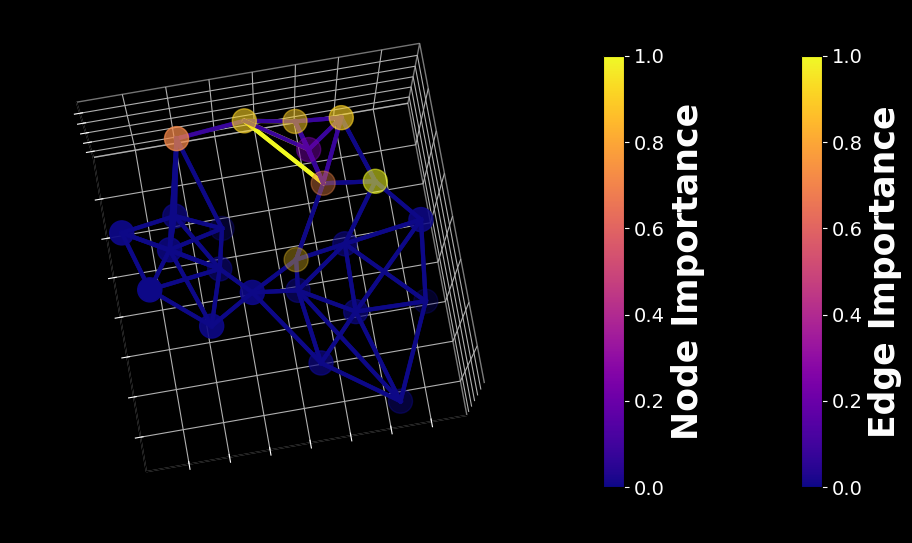

In [148]:
with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()

    node_cmap = plt.cm.plasma

    node_c = node_cmap(node_importance)

    ax.scatter(single_cell_proxi['row']*scale, single_cell_proxi['col']*scale, single_cell_proxi['z']*z_scale, '.', c=node_c, s=300)
    

    edge_cmap = plt.cm.plasma
    for i in range(edge_importance.shape[0]):
        edge_c = edge_cmap(edge_importance[i])
        ax.plot([single_cell_proxi.loc[edge_index[0][i]]['row'].astype('float')*scale, single_cell_proxi.loc[edge_index[1][i]]['row'].astype('float')*scale],
                [single_cell_proxi.loc[edge_index[0][i]]['col'].astype('float')*scale, single_cell_proxi.loc[edge_index[1][i]]['col'].astype('float')*scale],
                [single_cell_proxi.loc[edge_index[0][i]]['z'].astype('float')*z_scale, single_cell_proxi.loc[edge_index[1][i]]['z'].astype('float')*z_scale],
                c=edge_c,linewidth=3)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
    edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
    edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

    node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
    node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
    node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

    ax.view_init(-100, 100)
    plt.tight_layout()
    # plt.savefig(r'.\figures\cci_motif\bm_001_01_00_graph_importance.png')

In [162]:
feature_importance = np.sum(node_mask,axis=0)

In [170]:
important_idx = feature_importance.argsort()
important_idx = important_idx[::-1]
important_idx = important_idx[:10]

In [171]:
gene_pairs = proxi_df.columns[1:481]

In [172]:
for i in important_idx:
    print(gene_pairs[i])

IBSP_IBSP
CD105_CD105
CD105_IL8
COMP_IBSP
EEF2_IL8
HLA-DRA_IL8
CD105_IBSP
IL8_IL8
CD105_HLA-DRA
COL2A1_HLA-DRA


In [173]:
feature_importance[254]

0.0

In [174]:
important_idx

array([417, 142, 159, 355, 384, 408, 157, 437, 156, 323], dtype=int64)

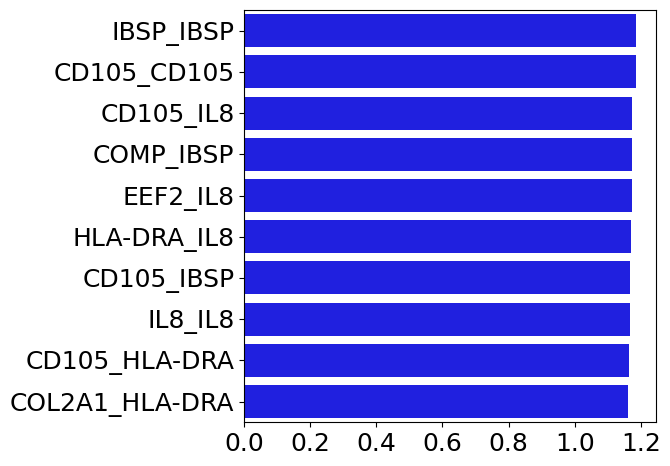

In [175]:
with rc_context({'text.color': 'black', 'axes.labelcolor': 'black', 'xtick.color': 'black', 'ytick.color': 'black', 'font.size':18}):
    ax,fig = plt.subplots(figsize=(7,5))
    sns.barplot(x=feature_importance[important_idx],y=gene_pairs[important_idx],color='blue')
    plt.tight_layout()
    plt.savefig(r'.\figures\cci_motif\bm_001_01_00_node_importance.png')

# Find motifs of high importance nodes and edges

In [178]:
in_dir = r'.\results\explainer\v2'
cell_l = os.listdir(in_dir)
cell_l.sort()

In [179]:
out_dir = r'.\results\explainer\motifs\motif'
for cell in tqdm(cell_l):
    single_cell_proxi = proxi_by_cell.get_group(cell)
    
    patch_l = os.listdir(os.path.join(in_dir,cell))
    patch_l.sort()

    for p in patch_l:
        edge_index = pd.read_pickle(os.path.join(edge_dir,cell,p))
        edge_index = edge_index['edges']
        explanation = pd.read_pickle(os.path.join(in_dir,cell,p))
        edge_mask = explanation['edge_mask']
        node_mask = explanation['node_mask']
        feature_importance = np.sum(node_mask,axis=0)
        node_importance = np.sum(node_mask,axis=1)
        node_importance = node_importance / np.max(node_importance)

        edge_importance = edge_mask / np.max(edge_mask)
        
        motif_nodes = np.where(node_importance>0.1)
        motif_node_features = proxi_df.loc[motif_nodes[0]]
        
        index_map = {}
        for i in range(len(motif_nodes[0])):
            index_map[motif_nodes[0][i]] = i
        motif_edge_index = [[],[]]
        for i in range(edge_index.shape[1]):
            if edge_index[0][i] in motif_nodes[0] and edge_index[1][i] in motif_nodes[0]:
                motif_edge_index[0].append(index_map[edge_index[0][i]])
                motif_edge_index[1].append(index_map[edge_index[1][i]])
        
        motif_node_features.reset_index(drop=True,inplace=True)
        
        with open(os.path.join(out_dir,p),'wb') as f:
            pickle.dump({'node_features':motif_node_features,'edge_index':motif_edge_index},f)

100%|██████████| 553/553 [06:28<00:00,  1.42it/s]


In [ ]:
with plt.rc_context({'text.color': 'white', 'axes.labelcolor': 'white', 'xtick.color': 'white', 'ytick.color': 'white'}):
    fig = plt.figure(figsize=(12,7))
    ax = fig.add_subplot(projection='3d')
    fig.set_facecolor('black')
    ax.set_facecolor('black')
    ax.w_xaxis.pane.fill = False
    ax.w_yaxis.pane.fill = False
    ax.w_zaxis.pane.fill = False
    ax.invert_zaxis()

    node_cmap = plt.cm.plasma

    node_c = node_cmap(node_importance)

    ax.scatter(single_cell_proxi['row']*scale, single_cell_proxi['col']*scale, single_cell_proxi['z']*z_scale, '.', c=node_c, s=300)
    

    edge_cmap = plt.cm.plasma
    for i in range(edge_importance.shape[0]):
        edge_c = edge_cmap(edge_importance[i])
        ax.plot([single_cell_proxi.loc[edge_index[0][i]]['row'].astype('float')*scale, single_cell_proxi.loc[edge_index[1][i]]['row'].astype('float')*scale],
                [single_cell_proxi.loc[edge_index[0][i]]['col'].astype('float')*scale, single_cell_proxi.loc[edge_index[1][i]]['col'].astype('float')*scale],
                [single_cell_proxi.loc[edge_index[0][i]]['z'].astype('float')*z_scale, single_cell_proxi.loc[edge_index[1][i]]['z'].astype('float')*z_scale],
                c=edge_c,linewidth=3)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    edge_mappable = plt.cm.ScalarMappable(cmap=edge_cmap)
    edge_cb = plt.colorbar(edge_mappable, ax=ax, label='Edge Importance', pad=0.1, shrink=0.8)
    edge_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    edge_cb.set_label('Edge Importance', color='white', weight='bold', fontsize=25)

    node_mappable = plt.cm.ScalarMappable(cmap=node_cmap)
    node_cb = plt.colorbar(node_mappable, ax=ax, label='Node Importance', pad=0.1, shrink=0.8)
    node_cb.ax.yaxis.set_tick_params(labelsize=14, color='white')
    node_cb.set_label('Node Importance', color='white', weight='bold', fontsize=25)

    ax.view_init(-100, 100)
    plt.tight_layout()
    # plt.savefig(r'.\figures\cci_motif\bm_001_01_00_graph_importance.png')

# Motif embedding

In [2]:
in_dir = r'.\results\explainer\motifs\motif_embedding'
motif_l = os.listdir(in_dir)
motif_l.sort()

In [3]:
motif_pool = []
for motif in tqdm(motif_l):
    temp = pd.read_pickle(os.path.join(in_dir,motif))
    temp = temp['embedding']
    motif_pool.append(np.mean(temp,axis=0))

100%|██████████| 9611/9611 [00:39<00:00, 245.94it/s]


In [4]:
temp = pd.read_pickle(r'.\results\signaling_analysis.pkl')
bm_boarder_pair = temp['bm_boarder_patch']
uc_boarder_pair = temp['uc_boarder_patch']
bm_interaction_type = temp['bm_interaction_type']
uc_interaction_type = temp['uc_interaction_type']

In [5]:
bm_arr = np.array(bm_boarder_pair)
uc_arr = np.array(uc_boarder_pair)
bm_type = np.array(bm_interaction_type)
uc_type = np.array(uc_interaction_type)

In [9]:
proxi_df

,index,ACAN_ACTb,ACAN_ALPL,ACAN_CCL11,ACAN_CCL19,ACAN_CD105,ACAN_CD11B,ACAN_CD19,ACAN_CD34,ACAN_CD45,...,RUNX1_SOX9,RUNX1_SPP1,SOX9_SPP1,SPP1_SPP1,cluster,row,col,z,cellID,patch_name
0,bm_001_01_0,0.000000,0.000000,0.000000,0.000000,2.848236,0.000000,-1.133975,-0.945549,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,167.983607,580.934426,13.459016,bm_001_01,bm_001_01_0
1,bm_001_01_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.333996,2.560510,-0.389507,0.000000,5,219.658333,492.091667,16.541667,bm_001_01,bm_001_01_1
2,bm_001_01_2,0.000000,0.000000,0.848949,0.000000,-0.968066,0.000000,0.000000,2.190913,0.000000,...,-0.229416,0.000000,0.000000,0.000000,1,137.956522,548.521739,13.391304,bm_001_01,bm_001_01_2
3,bm_001_01_3,0.000000,-0.280918,0.000000,-0.252646,-0.365896,-0.298339,-0.400994,-0.730901,0.000000,...,0.000000,0.000000,0.000000,5.843122,9,176.945455,526.390909,10.318182,bm_001_01,bm_001_01_3
4,bm_001_01_4,-0.198547,-0.262222,0.000000,3.404948,0.836933,-0.385988,-0.463018,-0.473670,0.000000,...,-0.278070,0.000000,0.000000,0.000000,0,148.495413,575.954128,14.669725,bm_001_01,bm_001_01_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25436,uc_047_05_46,-0.892481,-0.241702,-0.740149,-0.147904,4.127215,-0.166987,-0.148583,-0.872376,-0.850557,...,0.000000,1.842718,0.000000,8.325613,2,1724.725000,472.520000,12.935000,uc_047_05,uc_047_05_46
25437,uc_047_05_47,-1.753374,-0.306139,0.000000,-0.594225,-0.872577,-0.400392,-0.804755,-0.488768,-1.069667,...,0.000000,-0.399104,0.000000,-0.352473,8,1602.498728,531.333333,9.824427,uc_047_05,uc_047_05_47
25438,uc_047_05_48,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.739067,6,1488.423280,691.671958,10.142857,uc_047_05,uc_047_05_48
25439,uc_047_05_49,-1.193224,-0.274122,-0.386556,0.000000,-0.467144,-0.361698,2.846123,-0.415236,-0.290445,...,1.780727,0.922715,-0.521675,-0.487505,0,1857.138365,673.716981,10.062893,uc_047_05,uc_047_05_49


In [10]:
idx = np.where(bm_arr == 'bm_001_04_26')

In [11]:
type = bm_type[idx[0]]
dist = []
for item in idx[0]:
    pair = bm_arr[item,:]
    
    pos0 = proxi_df.loc[proxi_df['index'] == pair[0]]
    pos0 = pos0[['row','col','z']].values
    pos1 = proxi_df.loc[proxi_df['index'] == pair[1]]
    pos1 = pos1[['row','col','z']].values

    dist.append(np.linalg.norm(pos0-pos1))
print(dist)
m = np.argmin(dist)
type[m]

[336.9933425230536, 280.646909215237]


'homotypic'

In [12]:
def patch_labeling(patch):
    if '.pkl' in patch:
        patch = patch.split('.')[0]
    if 'bm' in patch:
        idx = np.where(bm_arr==patch)[0]
        interaction_type = bm_type[idx]
        if np.unique(interaction_type).shape[0] == 1:
            return 'bm_' + interaction_type[0]
        else:
            dist = []
            for item in idx:
                pair = bm_arr[item,:]

                pos0 = proxi_df.loc[proxi_df['index'] == pair[0]]
                pos0 = pos0[['row','col','z']].values
                pos1 = proxi_df.loc[proxi_df['index'] == pair[1]]
                pos1 = pos1[['row','col','z']].values

                dist.append(np.linalg.norm(pos0-pos1))
            m = np.argmin(dist)
            return 'bm_' + interaction_type[m]
    else:
        idx = np.where(uc_arr==patch)[0]
        interaction_type = uc_type[idx]
        if np.unique(interaction_type).shape[0] == 1:
            return 'uc_' + interaction_type[0]
        else:
            dist = []
            for item in idx:
                pair = uc_arr[item,:]

                pos0 = proxi_df.loc[proxi_df['index'] == pair[0]]
                pos0 = pos0[['row','col','z']].values
                pos1 = proxi_df.loc[proxi_df['index'] == pair[1]]
                pos1 = pos1[['row','col','z']].values

                dist.append(np.linalg.norm(pos0-pos1))
            m = np.argmin(dist)
            return 'uc_' + interaction_type[m]

In [13]:
label = Parallel(n_jobs=-2,verbose=100)(delayed(patch_labeling)(patch) for patch in motif_l)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 23 concurrent workers.
[Parallel(n_jobs=-2)]: Done   1 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   3 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   5 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   6 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   7 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   8 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done   9 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-2)]: Done  10 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  12 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  13 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  14 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-2)]: Done  15 tasks      | elapsed:  

In [14]:
motif_pool = np.array(motif_pool)

In [256]:
adata = sc.AnnData(motif_pool)
adata.obs['label'] = pd.Categorical(label, categories=['bm_homotypic','bm_heterotypic','uc_homotypic','uc_heterotypic'])
adata.uns['label_colors'] = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']

In [257]:
sc.pp.neighbors(adata, n_neighbors=10)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [258]:
sc.tl.umap(adata)
sc.tl.tsne(adata)

c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


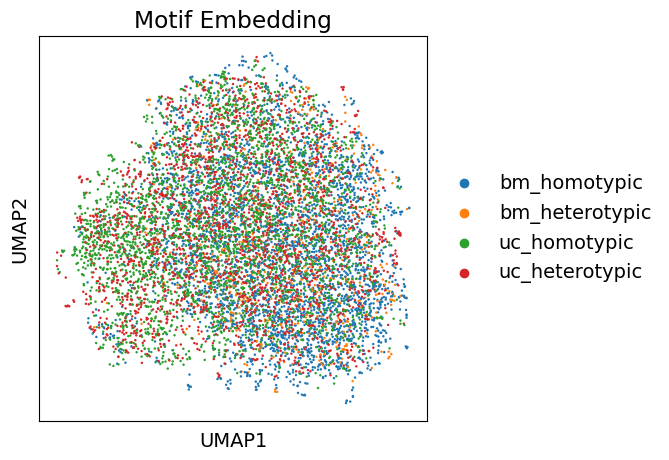

In [393]:
with rc_context({'figure.figsize':(5,5),'font.size':14}):
    sc.pl.umap(adata,color='label',title='Motif Embedding',save='_motif_label.png')

In [31]:
proxi_l = []
for motif in motif_l:
    if '.pkl' in motif:
        motif = motif.split('.')[0]
    idx = proxi_df['index'].tolist().index(motif)
    proxi_l.append(proxi_df.loc[idx])
proxi = pd.concat(proxi_l,axis=1).T

In [272]:
proxi_adata = sc.AnnData(proxi.values[:,1:481])
proxi_adata.obs['label'] = pd.Categorical(label, categories=['bm_homotypic','bm_heterotypic','uc_homotypic','uc_heterotypic'])
proxi_adata.var_names = proxi_df.columns[1:481]
proxi_adata.obs['cell_ids'] = proxi['index'].tolist()

In [273]:
sc.pp.neighbors(proxi_adata, n_neighbors=10)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [274]:
sc.tl.umap(proxi_adata)
sc.tl.tsne(proxi_adata)

c:\Users\zfang38\Anaconda3\envs\skim\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


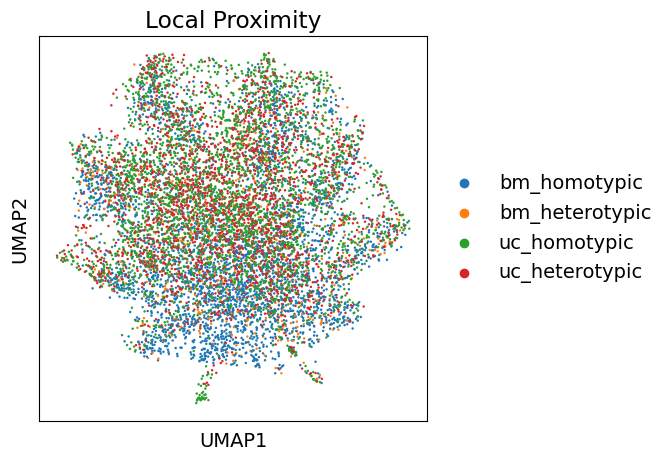

In [394]:
with rc_context({'figure.figsize':(5,5),'font.size':14}):
    sc.pl.umap(proxi_adata,color='label',title='Local Proximity',save='_boarder_proximity.png')

# Important features of each class

In [332]:
test_dir = r'Y:\coskun-lab\Zhou\4_HCR\3d_spagnn\spagnn\results\explainer\numpy'

In [338]:
node_masks = {'bm_homotypic':[],'bm_heterotypic':[],'uc_homotypic':[],'uc_heterotypic':[]}
for i,motif in enumerate(motif_l):
    m = motif.split('.')[0]
    temp = motif.split('_')
    cell = temp[0] + '_' + temp[1] + '_' + temp[2]
    temp = pd.read_pickle(os.path.join(test_dir,cell,motif))
    node_masks[label[i]].append(temp['node_mask'])

In [339]:
for k in node_masks.keys():
    node_masks[k] = np.concatenate(node_masks[k])

importance = {}
for k in node_masks.keys():
    importance[k] = np.sum(node_masks[k],axis=0)

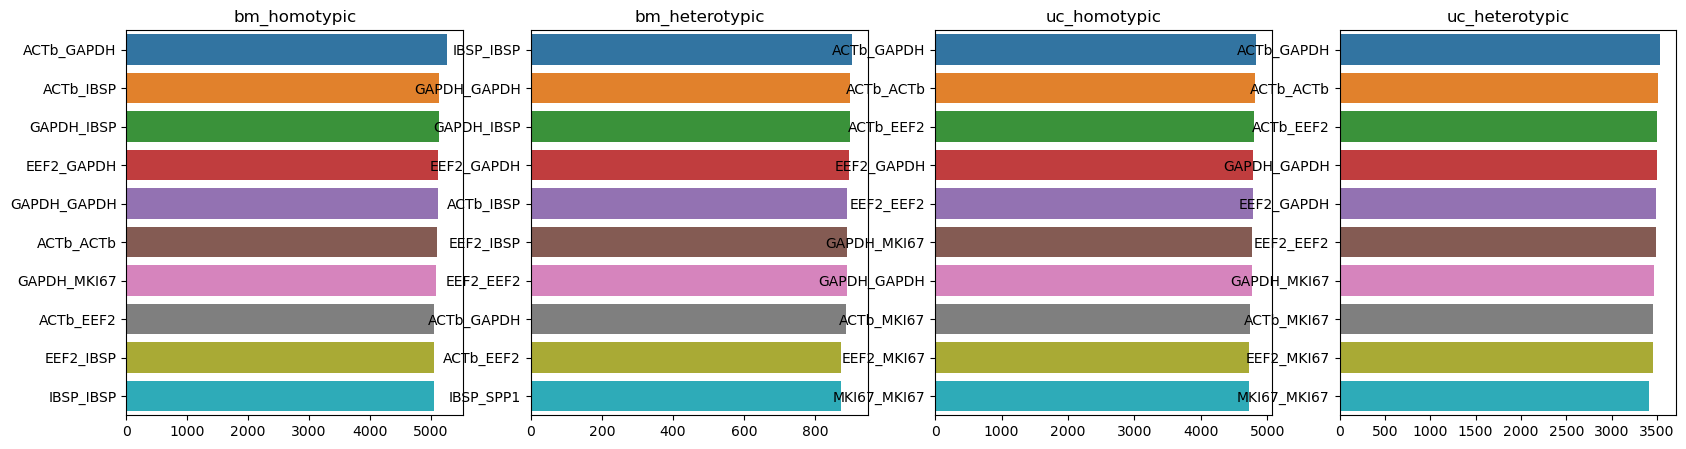

In [340]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
for i,k in enumerate(importance.keys()):
    mask = importance[k]
    idx = np.argsort(mask)[::-1]
    idx = idx[:10]
    sns.barplot(x=mask[idx],y=proxi_df.columns[1:481][idx],ax=ax[i])
    ax[i].set_title(k)

In [341]:
in_dir = r'.\results\explainer\motifs\motif_explanation'

In [346]:
node_masks = {'bm_homotypic':[],'bm_heterotypic':[],'uc_homotypic':[],'uc_heterotypic':[]}
for i,motif in enumerate(motif_l):
    temp = pd.read_pickle(os.path.join(in_dir,motif))
    node_masks[label[i]].append(temp['node_mask'])

In [347]:
for k in node_masks.keys():
    node_masks[k] = np.concatenate(node_masks[k])

importance = {}
for k in node_masks.keys():
    importance[k] = np.mean(node_masks[k],axis=0)

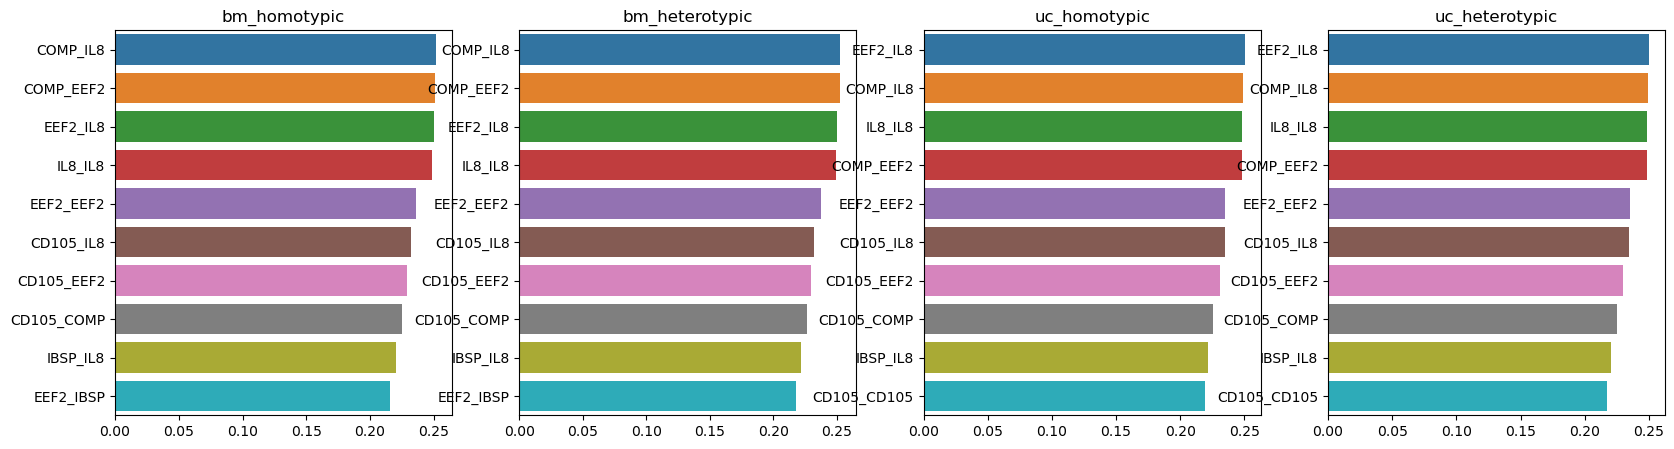

In [345]:
fig,ax = plt.subplots(1,4,figsize=(20,5))
for i,k in enumerate(importance.keys()):
    mask = importance[k]
    idx = np.argsort(mask)[::-1]
    idx = idx[:10]
    sns.barplot(x=mask[idx],y=proxi_df.columns[1:481][idx],ax=ax[i])
    ax[i].set_title(k)

In [348]:
mask = np.concatenate(list(node_masks.values()))

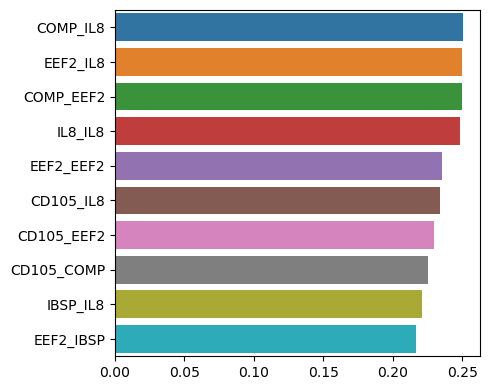

In [355]:
importance = np.mean(mask,axis=0)
idx = np.argsort(importance)[::-1]
idx = idx[:10]

fig,ax = plt.subplots(1,1,figsize=(5,4))
sns.barplot(x=importance[idx],y=proxi_df.columns[1:481][idx],ax=ax)
plt.tight_layout()
plt.savefig(r'.\figures\border patch feature importance.png',dpi=300)

# Motif classification based on proximity v. embedding

In [38]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [66]:
motif_train_x,motif_test_x,motif_train_y,motif_test_y = train_test_split(motif_pool,label,test_size=0.2,random_state=42)

In [67]:
clf = SVC(kernel='sigmoid',C=1)
clf.fit(motif_train_x,motif_train_y)
prediction = clf.predict(motif_test_x)

In [68]:
l = np.unique(label)
con = confusion_matrix(motif_test_y,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

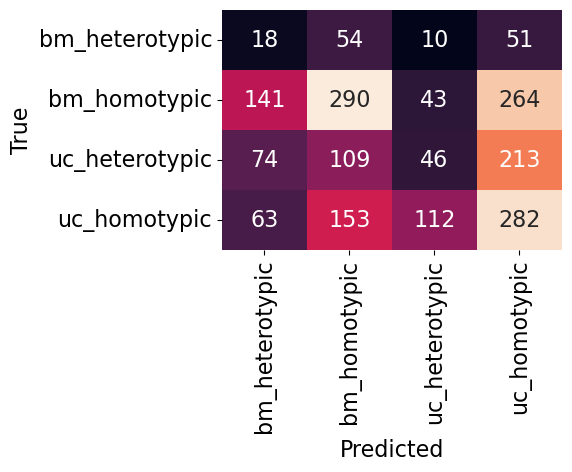

In [69]:
with rc_context({'font.size':16}):
    fig, ax = plt.subplots(1,1,figsize=(6,5))
    sns.heatmap(con,annot=True,fmt='g',ax=ax,cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    plt.savefig(r'.\figures\motif_classification.png',dpi=300)
    plt.show()

In [62]:
proxi_train_x,proxi_test_x,proxi_train_y,proxi_test_y = train_test_split(proxi.values[:,1:481],label,test_size=0.2,random_state=42)

In [63]:
clf.fit(proxi_train_x, proxi_train_y)
prediction = clf.predict(proxi_test_x)

In [64]:
l = np.unique(label)
con = confusion_matrix(proxi_test_y,prediction,labels=l)
con = pd.DataFrame(con, columns=l, index=l)

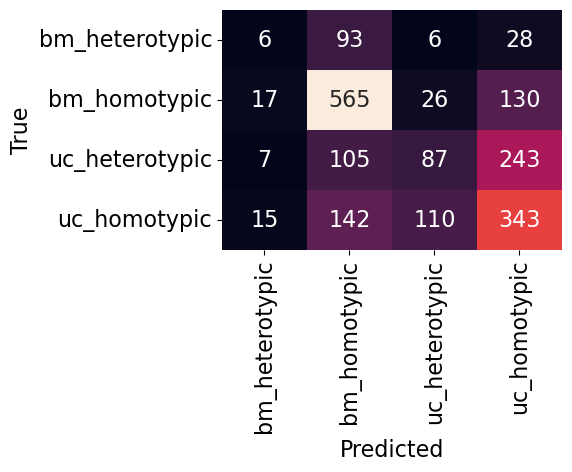

In [65]:
with rc_context({'font.size':16}):
    fig,ax = plt.subplots(1,1,figsize=(6,5))
    sns.heatmap(con,annot=True,fmt='g',ax=ax,cbar=False)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    plt.tight_layout()
    plt.savefig(r'.\figures\proxi_classification.png')
    plt.show()